In [1]:
from math import log
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence

    max_T, max_A = data.shape

    # Loop over time
    for t in range(max_T):
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            # Loop over possible alphabet outputs
            for c in range(max_A - 1):
                candidate = [seq + [c], score - log(data[t, c])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [3]:
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
        [0.4, 0.3, 0.5, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.3, 0.4, 0.5, 0.2, 0.1]]

data = np.array(data)

beam_width = 3

In [4]:
# decode sequence
result = beam_search_decoder(data, beam_width)
# print result
for i, seq in enumerate(result):
    print(i, seq)

0 [[3, 2, 3, 0, 3, 0, 3, 0, 3, 2], 8.047189562170502]
1 [[3, 2, 3, 0, 3, 0, 3, 0, 3, 1], 8.27033311348471]
2 [[3, 2, 3, 0, 3, 0, 3, 1, 3, 2], 8.27033311348471]


In [5]:
!wget --no-check-certificate "https://cl.indiana.edu/~ftyers/courses/2022/Autumn/L-645/practicals/beamsearch/output.json"

--2022-12-12 20:04:35--  https://cl.indiana.edu/~ftyers/courses/2022/Autumn/L-645/practicals/beamsearch/output.json
Resolving cl.indiana.edu (cl.indiana.edu)... 129.79.88.233
Connecting to cl.indiana.edu (cl.indiana.edu)|129.79.88.233|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 38733 (38K) [application/json]
Saving to: ‘output.json’

output.json         100%[===================>]  37.83K  --.-KB/s    in 0.03s   

2022-12-12 20:04:35 (1.18 MB/s) - ‘output.json’ saved [38733/38733]



### Exercise 1

Decode the output of acoustic model.

In [6]:
f = open('output.json')
data = json.load(f)

In [7]:
data.keys()

dict_keys(['alphabet', 'logits'])

In [11]:
logits = np.array(data['logits'])
beam_width = 5
answers = []

# decode sequence
result = beam_search_decoder(logits, beam_width)
ans = []
# Considering the last of the results as its with the highest log likelihood
for x in result[-1][0]:
    if len(ans) > 0 and data['alphabet'][x] == ans[-1]:
        continue
    else:
        ans.append(data['alphabet'][x])
ans = "".join(ans)
print(ans)

we mustsois find a newos tholme in the stsar os


### Exercise 2

Heatmap

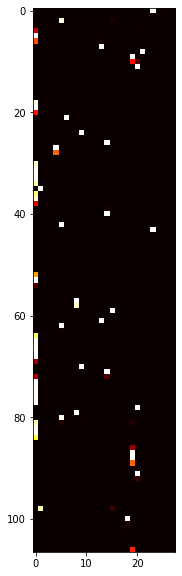

In [9]:
plt.figure(figsize=(10,10))
plt.imshow( logits , cmap = 'hot' , interpolation = 'nearest' )
plt.show()

Heatmap where darker colours are more probable.

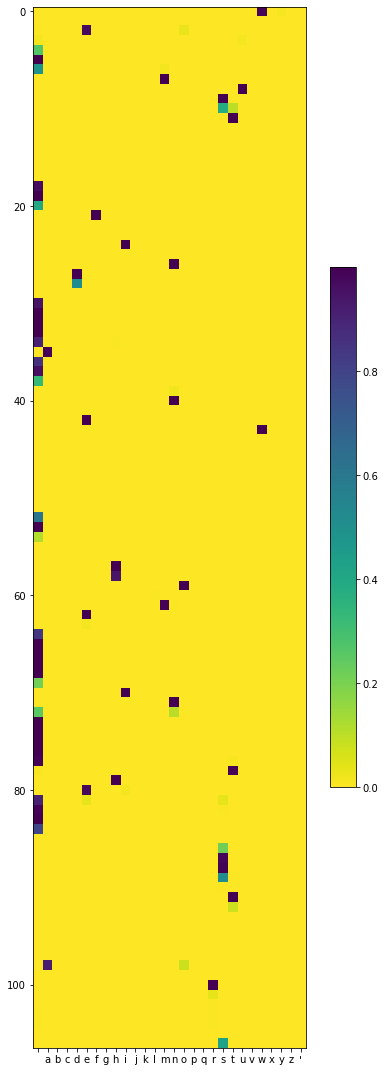

In [21]:
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()
fig, ax = plt.subplots(figsize=(7,15))
im = ax.imshow(logits, cmap=reversed_map)
ax.set_xticks(np.arange(len(data['alphabet'])))
ax.set_xticklabels(data['alphabet'])
cbar = ax.figure.colorbar(im, ax = ax, shrink=0.5 )
fig.tight_layout()

### Exercise 3

Decoding logits with CTC decoder

Reference: https://gist.githubusercontent.com/awni/56369a90d03953e370f3964c826ed4b0/raw/35b99ac85c5b4cfeb75682f059d3e876fe3a7d53/ctc_decoder.py

In [23]:
import numpy as np
import math
import collections

NEG_INF = -float("inf")

def make_new_beam():
  fn = lambda : (NEG_INF, NEG_INF)
  return collections.defaultdict(fn)

def logsumexp(*args):
  """
  Stable log sum exp.
  """
  if all(a == NEG_INF for a in args):
      return NEG_INF
  a_max = max(args)
  lsp = math.log(sum(math.exp(a - a_max)
                      for a in args))
  return a_max + lsp

def decode(probs, beam_size=100, blank=0):
  """
  Performs inference for the given output probabilities.

  Arguments:
      probs: The output probabilities (e.g. post-softmax) for each
        time step. Should be an array of shape (time x output dim).
      beam_size (int): Size of the beam to use during inference.
      blank (int): Index of the CTC blank label.

  Returns the output label sequence and the corresponding negative
  log-likelihood estimated by the decoder.
  """
  T, S = probs.shape
  probs = np.log(probs)

  # Elements in the beam are (prefix, (p_blank, p_no_blank))
  # Initialize the beam with the empty sequence, a probability of
  # 1 for ending in blank and zero for ending in non-blank
  # (in log space).
  beam = [(tuple(), (0.0, NEG_INF))]

  for t in range(T): # Loop over time

    # A default dictionary to store the next step candidates.
    next_beam = make_new_beam()

    for s in range(S): # Loop over vocab
      p = probs[t, s]

      # The variables p_b and p_nb are respectively the
      # probabilities for the prefix given that it ends in a
      # blank and does not end in a blank at this time step.
      for prefix, (p_b, p_nb) in beam: # Loop over beam

        # If we propose a blank the prefix doesn't change.
        # Only the probability of ending in blank gets updated.
        if s == blank:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_b = logsumexp(n_p_b, p_b + p, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)
          continue

        # Extend the prefix by the new character s and add it to
        # the beam. Only the probability of not ending in blank
        # gets updated.
        end_t = prefix[-1] if prefix else None
        n_prefix = prefix + (s,)
        n_p_b, n_p_nb = next_beam[n_prefix]
        if s != end_t:
          n_p_nb = logsumexp(n_p_nb, p_b + p, p_nb + p)
        else:
          # We don't include the previous probability of not ending
          # in blank (p_nb) if s is repeated at the end. The CTC
          # algorithm merges characters not separated by a blank.
          n_p_nb = logsumexp(n_p_nb, p_b + p)
          
        # *NB* this would be a good place to include an LM score.
        next_beam[n_prefix] = (n_p_b, n_p_nb)

        # If s is repeated at the end we also update the unchanged
        # prefix. This is the merging case.
        if s == end_t:
          n_p_b, n_p_nb = next_beam[prefix]
          n_p_nb = logsumexp(n_p_nb, p_nb + p)
          next_beam[prefix] = (n_p_b, n_p_nb)

    # Sort and trim the beam before moving on to the
    # next time-step.
    beam = sorted(next_beam.items(),
            key=lambda x : logsumexp(*x[1]),
            reverse=True)
    beam = beam[:beam_size]

  best = beam[0]
  return best[0], -logsumexp(*best[1])

In [24]:
label_sequence, nll = decode(logits)

In [28]:
label_sequence[0]

23

In [ ]:
# Considering the last of the results as its with the highest log likelihood
for x in result[-1][0]:
    if len(ans) > 0 and data['alphabet'][x] == ans[-1]:
        continue
    else:
        ans.append(data['alphabet'][x])
ans = "".join(ans)
print(ans)

In [30]:
answer_ctc = [data["alphabet"][x] for x in label_sequence]
answer_ctc_ = "".join(answer_ctc)
print(answer_ctc_)

wemustsisfindanewostholmeinthestsarrs
